## Tehtävä: Oppimisprojekti 2: Kuvantunnistus omilla kuvilla

Tämän projektin tavoitteena on suunnitella ja toteuttaa kuvantunnistusjärjestelmä käyttäen itse otettuja kuvia. Kuvadata koostuu hedelmistä (Omena, Päärynä, Mandariini, Banaani), ja tarkoituksena on testata eri mallien suorituskykyä tunnistaessa näitä hedelmiä kuvista.

Projekti toteutetaan vaiheittain hyödyntäen eri konvoluutioneuroverkkomenetelmiä yksinkertaisesta edistyneempään, sekä esikoulutettuja malleja, kuten VGG16, piirteiden irrottamiseen ja luokitteluun.

### Datan käsittely

In [1]:
from keras.src.utils import image_dataset_from_directory
import keras
from keras import Sequential, layers, regularizers
from keras.optimizers import Adam
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.preprocessing import image_dataset_from_directory

image_folder = '../week2_photodata/'

train_dataset = image_dataset_from_directory(
    image_folder+'train',
    labels='inferred',
    label_mode='categorical',
    image_size=(100,100),
    batch_size=4,
    shuffle=True
)

test_dataset = image_dataset_from_directory(
    image_folder+'test',
    labels='inferred',
    label_mode='categorical',
    image_size=(100,100),
    shuffle=True
)

validation_dataset = image_dataset_from_directory(
    image_folder+'validation',
    labels='inferred',
    label_mode='categorical',
    image_size=(100,100),
    shuffle=True
)
   
for images, labels in test_dataset:
    print(f"Batch of images shape: {images.shape}")

Found 180 files belonging to 4 classes.
Found 40 files belonging to 4 classes.
Found 40 files belonging to 4 classes.
Batch of images shape: (32, 100, 100, 3)
Batch of images shape: (8, 100, 100, 3)


2025-04-07 14:33:27.971859: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Oma CNN Malli

- Rakensimme oman konvoluutioverkon (CNN)
- Malli koulutettiin itse kerätyllä kuvadatalla
- Mallissa hyödynnettiin tietojen augmentointia parantamaan yleistettävyyttä

In [6]:
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.15),
  layers.RandomZoom(0.2)
])

model = Sequential([
    layers.Input(shape=(100,100, 3)),
    data_augmentation,
    layers.Rescaling(scale=1./255),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 33856)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       2,166,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,186,500 (8.34 MB)

 Trainable params: 2,186,500 (8.34 MB)

 Non-trainable params: 0 (0.00 B)

##### Oman CNN-mallin callback funktiot

In [7]:
# EarlyStopping callback to stop training when validation loss stops improving
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau callback to reduce the learning rate when validation loss plateaus
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

#### Oman CNN-mallin koulutus

In [8]:
# Model training
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping])

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.2903 - loss: 4.8988 - val_accuracy: 0.7500 - val_loss: 2.0318
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6943 - loss: 1.8618 - val_accuracy: 0.9500 - val_loss: 0.9216
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7574 - loss: 1.1289 - val_accuracy: 0.9000 - val_loss: 0.7444
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8568 - loss: 0.7043 - val_accuracy: 0.9750 - val_loss: 0.4764
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8605 - loss: 0.5992 - val_accuracy: 0.9750 - val_loss: 0.3587
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9434 - loss: 0.3846 - val_accuracy: 0.8500 - val_loss: 0.5147
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8684 - loss: 0.5798 - val_accuracy: 0.9750 - val_loss: 0.2611
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9391 - loss: 0.3212 - val_accuracy: 0.9750 - v

#### Oman CNN Mallin evaluaatio

- Mallin testihäviö (test_loss) ja testitarkkuus (test_accuracy) tulostettu
- Mallin häviön ja tarkkuuden kehitystä kuvaavat graafit esitetty

Test loss: 0.06
Test accuracy: 1.00


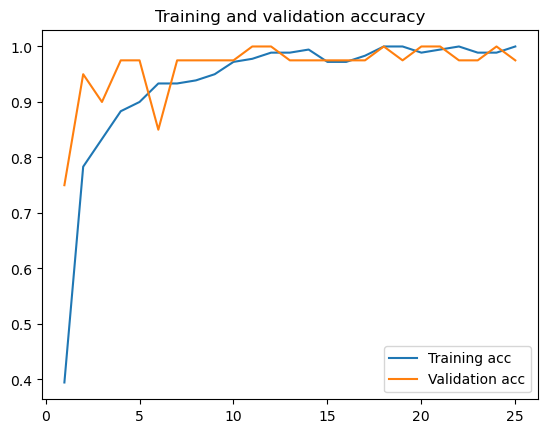

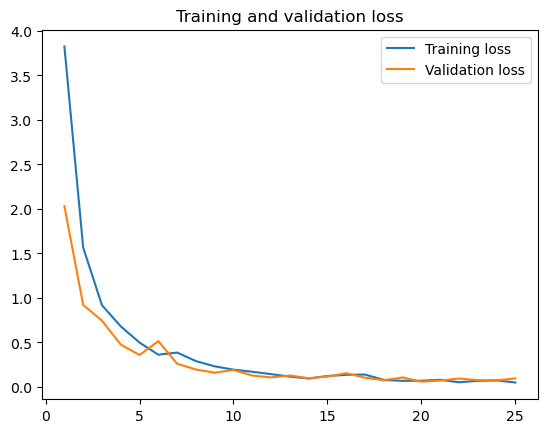

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

test_scores = model.evaluate(test_dataset, verbose=0)
print(f"Test loss: {test_scores[0]:.2f}")
print(f"Test accuracy: {test_scores[1]:.2f}")

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### VGG16 Malli (Esikoulutettu malli piirteenirroittajana)

- Käytimme VGG16 esikoulutettua mallia
- Skaalaamme kuvat 224 x 224 mallin vaatimaan kokoon
- Haemme pohjamallin kerasin applikaatiosta
- Jäädytämme pohjamallin kerrokset
- Lopuksi tulostamme pohjamallin

In [10]:
# Get new rescaled images for VGG16 model
train_dataset = image_dataset_from_directory(
    image_folder+'train',
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    batch_size=4,
    shuffle=True
)

test_dataset = image_dataset_from_directory(
    image_folder+'test',
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    shuffle=True
)

validation_dataset = image_dataset_from_directory(
    image_folder+'validation',
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    shuffle=True
)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

# Feature extraction
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)
feature_extractor.summary()

Found 180 files belonging to 4 classes.
Found 40 files belonging to 4 classes.
Found 40 files belonging to 4 classes.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

#### VGG16 Malli (Esikoulutettu malli piirteenirroittajana) ominaisuudet

- Ominaisuuksien irroitusfunktio ja ominaisuuksien irroitus
- Ominaisuudet printattuna

In [11]:
def extract_features(dataset, feature_extractor):
    features = []
    labels = []

    for images, lbls in dataset:
        preprocessed_image = keras.applications.vgg16.preprocess_input(images)
        features.append(feature_extractor.predict(preprocessed_image))
        labels.append(lbls)

    return np.concatenate(features), np.concatenate(labels)

train_features, train_labels = extract_features(train_dataset, feature_extractor)
val_features, val_labels = extract_features(validation_dataset, feature_extractor)
test_features, test_labels = extract_features(test_dataset, feature_extractor)

print(f"Train features shape: {train_features.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

#### VGG16 Malli (Esikoulutettu malli piirteenirroittajana) mallin rakentaminen

- Ominaisuuksein muotoilu dense verkkoa varten
- Dense verkon rakennus

In [12]:
# muunnetaan vektori muotoon
train_features = train_features.reshape(train_features.shape[0], -1)
val_features = val_features.reshape(val_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

dense_model = Sequential([
    Dense(64, activation='relu', input_shape=(train_features.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

dense_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\M_Hin\anaconda3\envs\Tensor\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### VGG16 Malli (Esikoulutettu malli piirteenirroittajana) mallin koulutus

- early_stop ja reduce_lr funktioiden määritys
- Mallin koulutus

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Train the model
history_vgg16 = dense_model.fit(
    train_features, train_labels,
    validation_data=(val_features, val_labels),
    batch_size=32,
    epochs=60,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/60


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.4179 - loss: 8.4005 - val_accuracy: 1.0000 - val_loss: 0.0193 - learning_rate: 0.0010
Epoch 2/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7580 - loss: 4.0605 - val_accuracy: 0.9500 - val_loss: 0.1442 - learning_rate: 0.0010
Epoch 3/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8150 - loss: 2.9622 - val_accuracy: 1.0000 - val_loss: 9.8721e-04 - learning_rate: 0.0010
Epoch 4/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8808 - loss: 2.8710 - val_accuracy: 1.0000 - val_loss: 2.6544e-04 - learning_rate: 0.0010
Epoch 5/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8295 - loss: 2.1431 - val_accuracy: 1.0000 - val_loss: 9.7917e-06 - learning_rate: 0.0010
Epoch 6/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8922 - loss: 2.0394 - val_accuracy: 1.0000 - val_loss: 3.5763e-07 - learning_rate: 0.0010
Epoch 7/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9238 - loss: 0.8913 - val_accuracy: 1.

#### VGG16 Malli (Esikoulutettu malli piirteenirroittajana) evaluaatio

Tulostamme mallin tehokkuuden ja piirrämme graafit

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Feature extractor model test loss: 0.00
Feature extractor model test accuracy: 1.00


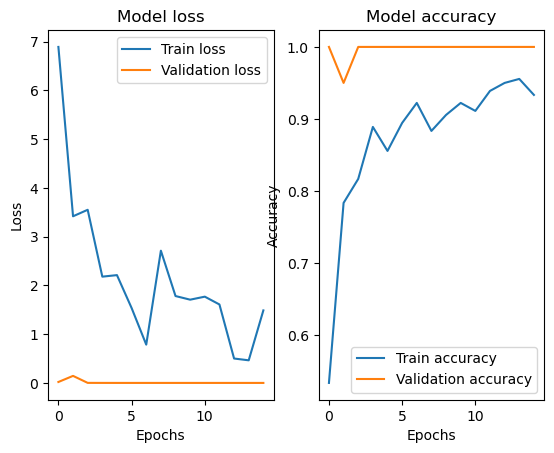

In [14]:
test_loss, test_acc = dense_model.evaluate(test_features, test_labels, verbose=1)
print(f"Feature extractor model test loss: {test_loss:.2f}")
print(f"Feature extractor model test accuracy: {test_acc:.2f}")

plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['loss'], label='Train loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['accuracy'], label='Train accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation accuracy')
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#### Mallien suorituskyvyn vertailu

Oma CNN-mallimme koulutettiin alusta alkaen omalla kuvadatalla. Mallin suorituskyky mitattiin testidatalla seuraavasti:
- Test loss: 0.06
- Test accuracy: 1.00

Esikoulutettua VGG16-mallia koulutettiin siten, että VGG16:n alkuperäisiä painoja ei päivitetty (feature extraction). Mallin suorituskyky mitattiin testidatalla seuraavasti:
- Test loss: 0.00
- Test accuracy: 1.00

CNN-mallimme suorituskyky testidatalla oli erinomainen, ja sen hyvä suorituskyky pienellä datalla kertoo, että malli on oppinut tunnistamaan datassa esiintyvät selkeät piirteet.

VGG16-malli hyödynsi esikoulutettuja painoja ja toimi feature extraction -menetelmällä, eli mallia käytettiin piirteiden poimintaan. VGG16-mallin testitulos oli myös erinomainen, ja VGG16:n etuna on sen kyky oppia monimutkaisempia piirteitä, mikä olisi hyödyllistä monimutkaisemmissa tehtävissä.

VGG16-mallin yleiset piirteet auttavat sitä suorittamaan hyvin validointidatassa, mutta harjoitustarkkuuden ja -häviön vaihtelu voi johtua siitä, että hienosäädetyt kerrokset oppivat vaikeammin, kun datamme ei ole kovin monimutkaista ja mallin ei ole tarpeen tehdä suuria muutoksia esikoulutettuihin painoihin.

Koska datamme on melko yksinkertaista, oma CNN toimii tässä tapauksessa paremmin.

#### VG116 (Hienosäädetty esikoulutettu malli)

- Haemme pohjamallin kerasin kirjastosta
- Jäädytämme pohjamallin kerrokset
- Luomme oman dense verkon ja printtaamme sen lopuksi

In [2]:
# Get new rescaled images for VGG16 model
train_dataset = image_dataset_from_directory(
    image_folder+'train',
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    batch_size=4,
    shuffle=True
)

test_dataset = image_dataset_from_directory(
    image_folder+'test',
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    shuffle=True
)

validation_dataset = image_dataset_from_directory(
    image_folder+'validation',
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    shuffle=True
)

# Define data augmentation layer
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.15),
])

# Load the VGG16 model, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False)
#base_model.trainable = False

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = base_model(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x) 
x = Dense(16, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)

# Create the new model
model_vgg16_tuned = Model(inputs, outputs)

model_vgg16_tuned.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_vgg16_tuned.summary()

Found 180 files belonging to 4 classes.
Found 40 files belonging to 4 classes.
Found 40 files belonging to 4 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │    802,848 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32)        │        128 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │         68 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,518,260 (59.20 MB)

 Trainable params: 803,508 (3.07 MB)

 Non-trainable params: 14,714,752 (56.13 MB)

#### VG116 (Hienosäädetty esikoulutettu malli) koulutus

Mallin ylempien kerroksien koulutus omalla datalla.

In [3]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Train the model
history_vgg16 = model_vgg16_tuned.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 481ms/step - accuracy: 0.2515 - loss: 1.8803 - val_accuracy: 0.6000 - val_loss: 0.8845
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 507ms/step - accuracy: 0.6072 - loss: 0.9911 - val_accuracy: 0.8250 - val_loss: 0.6100
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 519ms/step - accuracy: 0.7321 - loss: 0.7251 - val_accuracy: 0.9000 - val_loss: 0.3547
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 529ms/step - accuracy: 0.6901 - loss: 0.7897 - val_accuracy: 0.9750 - val_loss: 0.2612
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7396 - loss: 0.6594 - val_accuracy: 0.9750 - val_loss: 0.1678
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 889ms/step - accuracy: 0.8423 - loss: 0.6259 - val_accuracy: 0.9750 - val_loss: 0.1498
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 746ms/step - accuracy: 0.8530 - loss: 0.5355 - val_accuracy: 1.0000 - val_loss: 0.1232
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 33s 726ms/step - accuracy: 0.7821 - loss: 0.5552 - val_accurac

#### VG116 (Hienosäädetty esikoulutettu malli) evaluaatio

Mallin evaluaatio, printataan tehokkuusluvut ja piirretään graafit häviön ja tarkkuuden osalta.

VGG16 Test loss: 0.03
VGG16 Test accuracy: 1.00


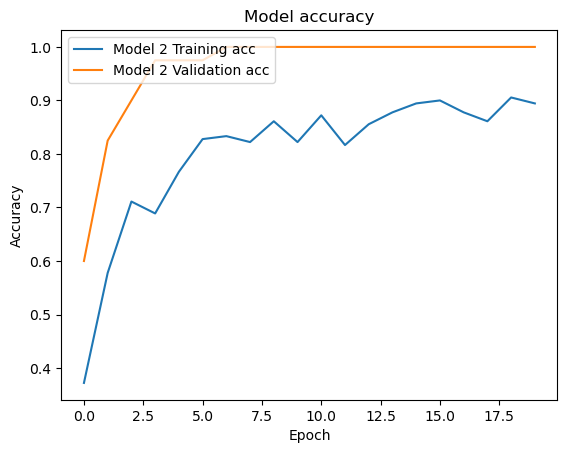

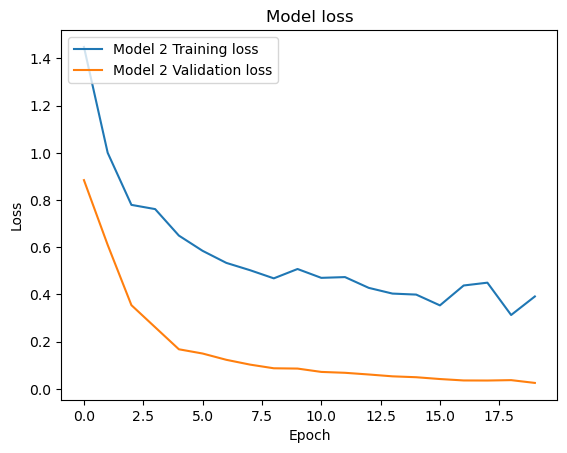

In [4]:
import matplotlib.pyplot as plt

# Evaluate the model
test_scores_vgg16 = model_vgg16_tuned.evaluate(test_dataset, verbose=0)
print(f"VGG16 Test loss: {test_scores_vgg16[0]:.2f}")
print(f"VGG16 Test accuracy: {test_scores_vgg16[1]:.2f}")

# Plot training & validation accuracy values
plt.plot(history_vgg16.history['accuracy'], label='Model 3 Training acc')
plt.plot(history_vgg16.history['val_accuracy'], label='Model 3 Validation acc')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_vgg16.history['loss'], label='Model 3 Training loss')
plt.plot(history_vgg16.history['val_loss'], label='Model 3 Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

#### VG116 (Hienosäädetty esikoulutettu malli) koulutus omalla datalla

Avataan jäädytetyt ylemmät kerrokset ja koulutetaan niitä omalla datalla

In [5]:
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Model compile
model_vgg16_tuned.compile(loss="categorical_crossentropy", optimizer=Adam(0.0001), metrics=["accuracy"])

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

history = model_vgg16_tuned.fit(
    train_dataset,
    epochs = 25,
    validation_data= validation_dataset,
    callbacks=[early_stopping]
)

Epoch 1/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 550ms/step - accuracy: 0.8970 - loss: 0.4075 - val_accuracy: 1.0000 - val_loss: 0.0257
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 799ms/step - accuracy: 0.9120 - loss: 0.2923 - val_accuracy: 1.0000 - val_loss: 0.0209
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 856ms/step - accuracy: 0.8746 - loss: 0.3897 - val_accuracy: 1.0000 - val_loss: 0.0140
Epoch 4/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 804ms/step - accuracy: 0.9362 - loss: 0.2511 - val_accuracy: 1.0000 - val_loss: 0.0110
Epoch 5/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 755ms/step - accuracy: 0.9228 - loss: 0.3565 - val_accuracy: 1.0000 - val_loss: 0.0115
Epoch 6/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 768ms/step - accuracy: 0.8906 - loss: 0.3793 - val_accuracy: 1.0000 - val_loss: 0.0105
Epoch 7/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 777ms/step - accuracy: 0.9394 - loss: 0.2590 - val_accuracy: 1.0000 - val_loss: 0.0120
Epoch 8/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 793ms/step - accuracy: 0.8115 - loss: 0.4389 - val_accu

#### VG116 (Hienosäädetty esikoulutettu malli)

Mallin plottaus ja printtaus

VGG16 Fine-tuned Test loss: 0.01
VGG16 Fine-tuned Test accuracy: 1.00


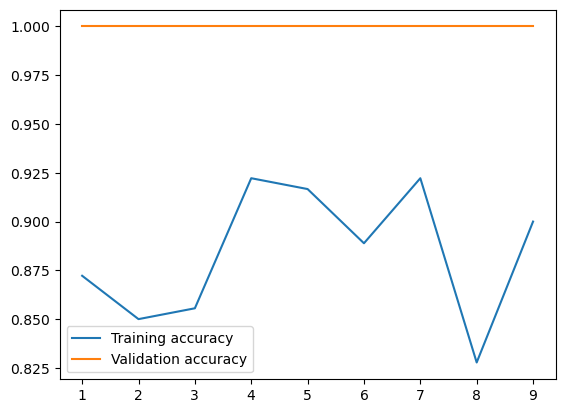

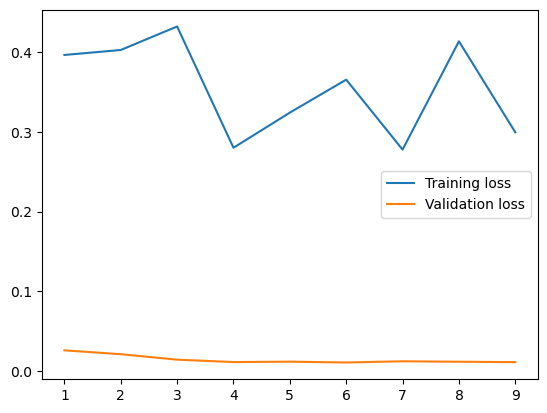

In [7]:
test_loss, test_acc = model_vgg16_tuned.evaluate(test_dataset, verbose=0)
print(f"VGG16 Fine-tuned Test loss: {test_loss:.2f}")
print(f"VGG16 Fine-tuned Test accuracy: {test_acc:.2f}")

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = list(range(1, len(accuracy)+1))
plt.plot(epochs, accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.legend()
plt.show()

Hienosäädetty VGG16-malli on ensin jäädytetty, mutta sitten sen yläkerrokset on avattu ja koulutettu omalla datalla. Tämä lähestymistapa mahdollistaa mallin oppimisen lisäämällä uusia piirteitä ja säätämällä aiempia kerroksia.

- Test loss: 0.01
- Test accuracy: 1.00

Hienosäätö tuo mallille etuja piirteiden oppimisessa ja se saavuttikin erinomaisen tarkkuuden.

#### Yhteenveto ja Analyysi

Tuloksia ja graafeja tarkastelemalla huomasimme, että validointidata voisi olla monipuolisempaa.